In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### In this notebook, I will train two different kinds of models (Random Forest and SVM) on different aspects of my data and produce predictions

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
# read in data
book_data = pd.read_csv('../data/book_data.csv')

In [5]:
# remove unnamed columns
book_data.drop(columns='Unnamed: 0', inplace=True)

In [6]:
# drop rows with na values. These are rows with no words to lemmatize from the previous notebook
book_data.dropna(inplace=True)

#### Define X, y and Train Test Sets

In [7]:
# Define X and y for vectorized data
X = book_data[['lemmatized_words']]
y = book_data['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, stratify=y)

### Count Vectorization and Tfidf Vectorization
#### This will be used for modelling

In [9]:
# define custom stop words. English stop words have already been removed
# these mostly consist of words that appear in reddit posts but have little to do with the actual text.
# many are related to links and reddit text formatting
book_stopwords = ['like', 'reddit', 'https', 'view', 'http', 'gt', 'lt', 'www', 'amp', 'x200b', 'imgur', 'com', 'org', 'index', 'php', 'poll']

In [84]:
# Instantiate Count Vectorizer for ngrams = 1
cvec = CountVectorizer(max_features=5000, stop_words=book_stopwords, ngram_range=(1,2))

In [85]:
# Fit and Transform book data
X_train_cv = cvec.fit_transform(X_train['lemmatized_words'])
X_test_cv = cvec.transform(X_test['lemmatized_words'])

In [86]:
# Convert to DataFrames
X_train_cv_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())
X_test_cv_df = pd.DataFrame(X_test_cv.todense(), columns=cvec.get_feature_names())

In [79]:
# Instantiate Tfidf Vectorizer for ngrams = 1
tvec = TfidfVectorizer(max_features = 5000, stop_words = book_stopwords, ngram_range=(1,2))

In [80]:
# Fit and Transform book train data
X_train_tv = tvec.fit_transform(X_train['lemmatized_words'])
X_test_tv = tvec.transform(X_test['lemmatized_words'])

In [81]:
# Convert to DataFrame
X_train_tv_df = pd.DataFrame(X_train_tv.todense(), columns=tvec.get_feature_names())
X_test_tv_df = pd.DataFrame(X_test_tv.todense(), columns=tvec.get_feature_names())

/home/mark/Python/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Random Forest Modelling

In [82]:
# Establish Baseline Accuracy
y.value_counts(normalize=True)[0]

0.5126475548060708

In [95]:
# Instantiate Random Forest
rf = RandomForestClassifier(n_estimators=100)

In [90]:
# Fit model
rf.fit(X_train_cv_df, y_train)

RandomForestClassifier()

In [91]:
# test accuracy
rf.score(X_test_cv_df, y_test)

0.9308600337268128

In [93]:
# train accuracy
rf.score(X_train_cv_df, y_train)

0.9893198426082068

In [94]:
# Cross validation on Count Vectorized data
cross_val_score(rf, X_train_cv_df, y_train, cv=5).mean()

0.9224434245924987

In [96]:
# Cross validation on Tfidf Vectorized data
cross_val_score(rf, X_train_tv_df, y_train, cv=5).mean()

0.9173872448172178

#### After some initial modelling, Random Forest seems to perform best on Count Vectorized data. I will now Grid Search for the best hyperparameters

In [138]:
# define parameter Grid
rf_params = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 2, 4, 6, 8]
}

In [139]:
# instantiate Random Forest and Grid Search CV
rf = RandomForestClassifier()
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)

In [140]:
# Fit Gridsearch object
gs.fit(X_train_cv_df, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 14],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [141]:
# Get best parameters and best score
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': None, 'n_estimators': 250}
0.9263728438043994


In [142]:
# Score on test data
gs.score(X_test_cv_df, y_test)

0.9342327150084317

#### After Grid Searching for best parameters, accuracy has increased slightly on the test data

In [143]:
# Make Predictions
y_preds = gs.predict(X_test_cv_df)

In [144]:
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['ASoIaF', 'Stormlight Archive'])

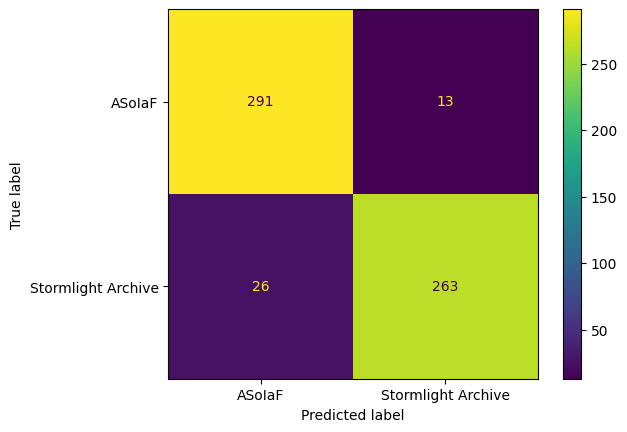

In [146]:
# Display confusion matrix
cm_display.plot()
plt.show()

In [147]:
rf = RandomForestClassifier(max_depth=None, n_estimators=250)

In [148]:
# Fit Random Forest
rf.fit(X_train_cv_df, y_train)

RandomForestClassifier(n_estimators=250)

In [149]:
# sort feature importance indexes
sorted_index = rf.feature_importances_.argsort()

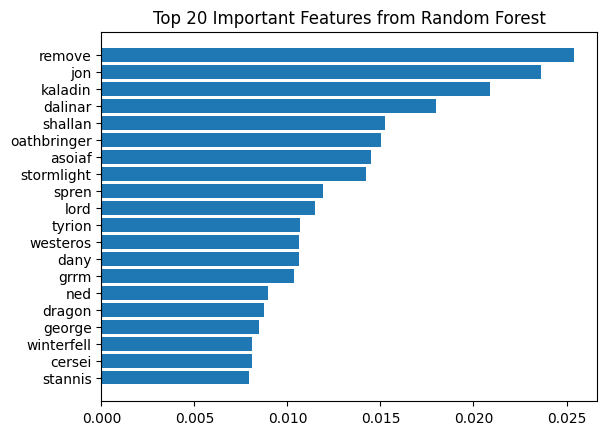

In [150]:
# plot most important features
plt.title('Top 20 Important Features from Random Forest')
plt.barh(X_train_cv_df.columns[sorted_index][-20:], rf.feature_importances_[sorted_index][-20:]);

### SVM Modelling

In [153]:
# Define parameter grid for grid searching C value
pgrid = {'C': np.logspace(-1, 2, 10)}

In [154]:
# Instantiate SVM and Grid Search objects
svm = SVC(random_state=16)
gs = GridSearchCV(svm, pgrid, cv=5)

In [155]:
# Fit
gs.fit(X_train_cv_df, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=16),
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ])})

In [156]:
# Get best parameters and best score
print(gs.best_params_)
print(gs.best_score_)

{'C': 10.0}
0.9106361766102232


In [157]:
# Score on test data
gs.score(X_test_cv_df, y_test)

0.9190556492411467

In [158]:
# Make Predictions
y_preds = gs.predict(X_test_cv_df)

In [160]:
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['ASoIaF', 'Stormlight Archive'])

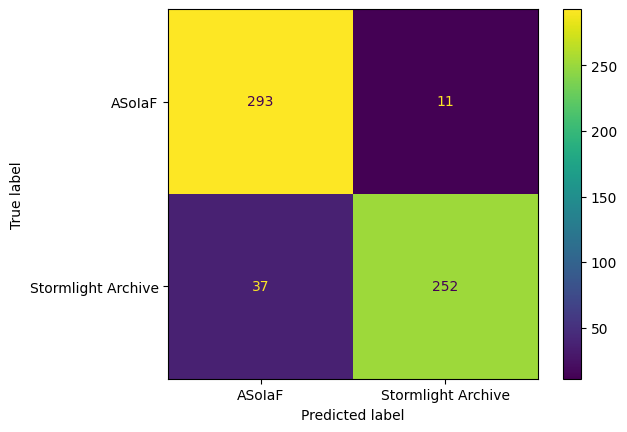

In [161]:
# Display confusion matrix
cm_display.plot()
plt.show()

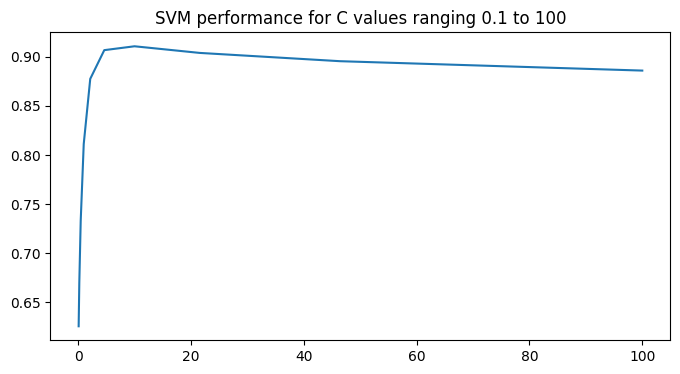

In [164]:
# Plot SVM score for C values
df_gs = pd.DataFrame(gs.cv_results_)
plt.figure(figsize=(8, 4))
plt.title('SVM performance for C values ranging 0.1 to 100')
plt.plot(df_gs.param_C, df_gs.mean_test_score);

### Model Performance

After testing both the Count Vectorized and the Tfidf Vectorized data, the models performed best with the Count Vectorized data. Random Forest performed the best with a final test accuracy of 0.9342. SVM had a final test accuracy of 0.9190.